## Czesc 1

In [1]:
from IPython.core.display_functions import display
from sklearn.datasets import make_classification
import numpy as np
from numpy.linalg import pinv
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score
from time import time_ns
from sklearn.pipeline import Pipeline
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
random_state = 244827
n_samples = 2427

In [3]:
# def norm(x, a, b):
#     return ((x - np.min(x)) / (np.max(x) - np.min(x))) * (b-a) - a

In [4]:
raw_x, raw_y = make_classification(n_samples=n_samples, random_state=random_state, n_features=2, n_clusters_per_class=1, n_redundant=0, n_classes=2)
x_train, x_test, y_train, y_test = train_test_split(raw_x, raw_y, test_size=0.2, random_state=random_state, shuffle=True)

# x_min = np.min(x_train)
# x_max = np.max(x_train)
# x_train = (x_train - x_min) / (x_max - x_min)
# x_test = (x_test - x_min) / (x_max - x_min)

y_test[y_test == 0] = -1
y_train[y_train == 0] = -1

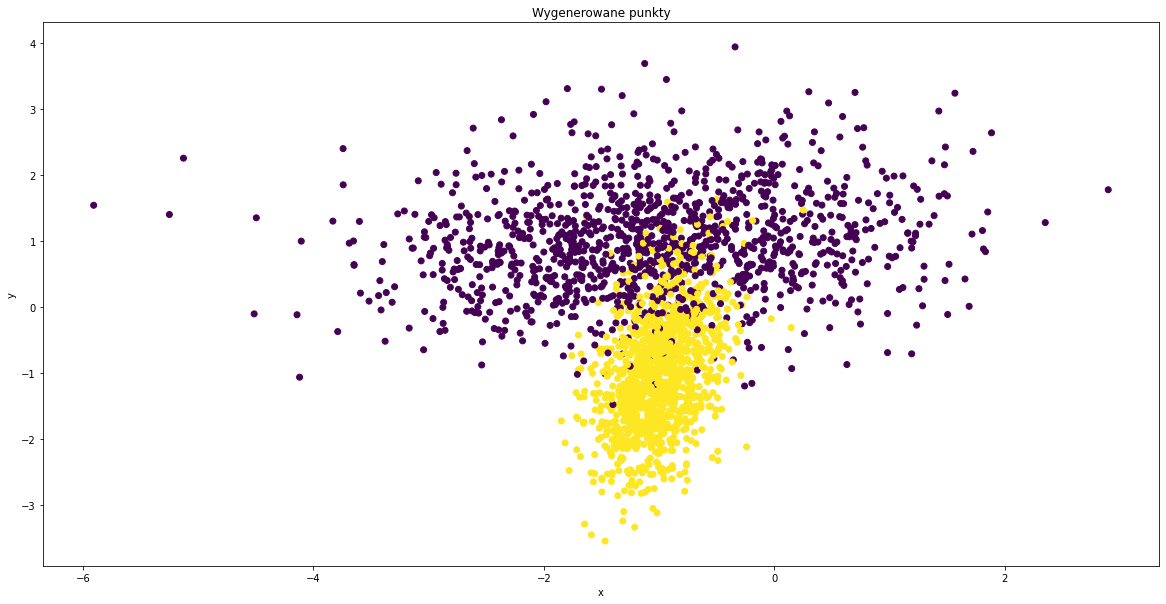

In [5]:
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train)
plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test)
plt.xlabel('x')
plt.ylabel('y')
# plt.legend()
plt.title("Wygenerowane punkty")
plt.show()

In [6]:
def ridge_regression(X: np.ndarray, Y: np.ndarray, alpha=1e-50):
    intercept_ones = np.ones((len(X),1))
    X_biased = np.c_[intercept_ones,X]
    I = np.identity(X_biased.shape[1])
    I[0][0] = 0
    w = np.linalg.inv(X_biased.T.dot(X_biased) + alpha * I).dot(X_biased.T).dot(Y)
    w = w.reshape((len(w), 1))
    return w

In [7]:
def f_wielomian(w: np.ndarray, x: np.ndarray):
    x = np.c_[np.ones((x.shape[0], 1)), x]
    y = np.sum(np.dot(x, w), axis=1)
    return y

In [8]:
def assign_labels(y, d=0, a=-1, b=1):
    y[y < d] = a
    y[y >= d] = b
    return y

(486,)
Implementacja własna działała średnio 	94237.0 nanosekund
Implementacja sklearn działała średnio 	942402.0 nanosekund
Oba modele osiągnęy ten sam wynik: sensitivity: 0.889795918367347, specifity: 0.8713692946058091
Czulość: 0.8713692946058091, swoistość: 0.889795918367347


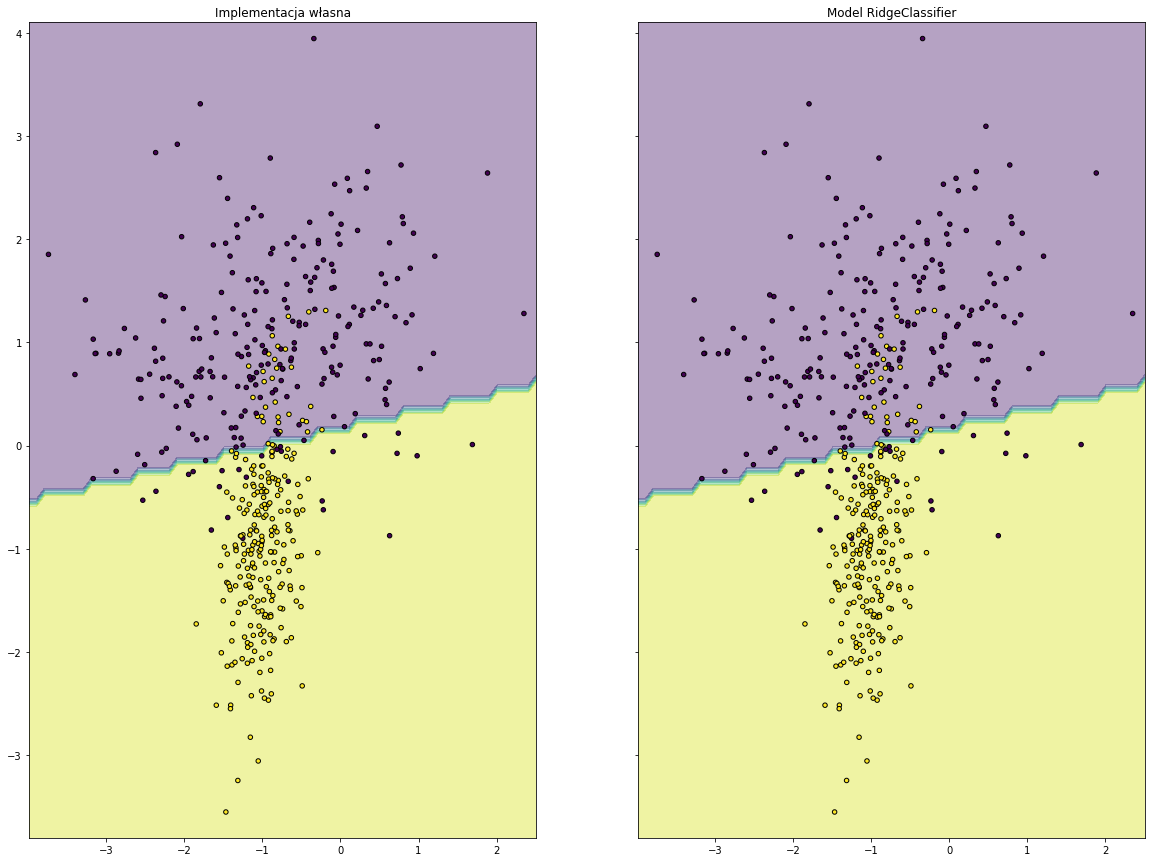

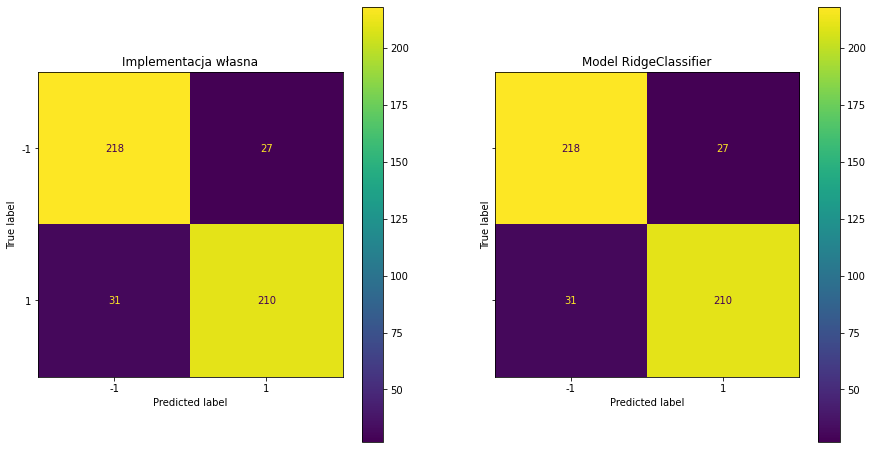

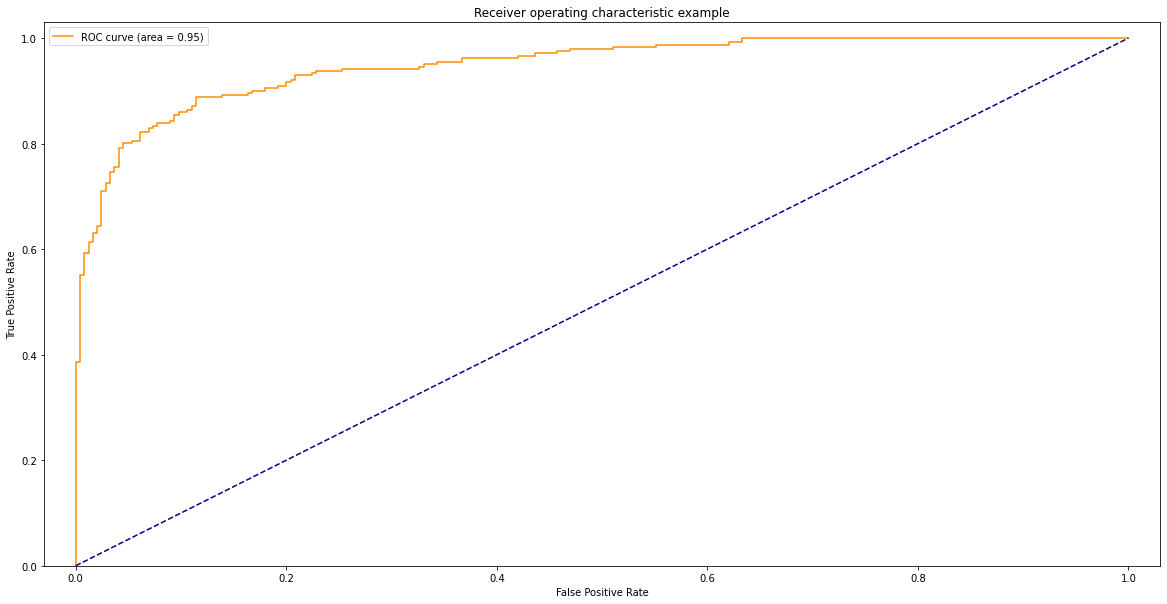

In [9]:
def synthetic_conparrision():
    x_min, x_max = x_test[:, 0].min() - 0.25, x_test[:, 0].max() + 0.25
    y_min, y_max = x_test[:, 1].min() - 0.25, x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    an_start = time_ns()
    for _ in range(100):
        w = ridge_regression(x_train, y_train)
    an_time = time_ns() - an_start

    Z_an = assign_labels(f_wielomian(w, np.c_[xx.ravel(), yy.ravel()]))
    Z_an = Z_an.reshape(xx.shape)

    sk_start = time_ns()
    for _ in range(100):
        model = RidgeClassifier()
        model.fit(x_train, y_train)
    sk_time = time_ns() - sk_start

    Z_sk = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_sk = Z_sk.reshape(xx.shape)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(20, 15))

    for idx, Z, title in zip(
        range(2),
        [Z_an, Z_sk],
        ['Implementacja własna', 'Model RidgeClassifier']):
        axarr[idx].contourf(xx, yy, Z, alpha=0.4)
        axarr[idx].scatter(x_test[:, 0], x_test[:, 1], c=y_test, s=20, edgecolor="k")
        axarr[idx].set_title(title)

    y_sk_predicted = model.predict(x_test)
    y_an_predicted = assign_labels(f_wielomian(w, x_test))

    print(y_an_predicted.shape)

    cm_sk = confusion_matrix(y_test, y_sk_predicted)
    cm_an = confusion_matrix(y_test, y_an_predicted)


    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

    for idx, cm, title in zip(
        range(2),
        [cm_an, cm_sk],
        ['Implementacja własna', 'Model RidgeClassifier'],
    ):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        axarr[idx].set_title(title)
        disp.plot(ax=axarr[idx])

    print(f'Implementacja własna działała średnio \t{an_time / 100} nanosekund')
    print(f'Implementacja sklearn działała średnio \t{sk_time / 100} nanosekund')

    sensitivity = cm_sk[0, 0] / (cm_sk[0, 0] + cm_sk[0, 1])
    specifity = cm_sk[1, 1] / (cm_sk[1, 0] + cm_sk[1, 1])

    print(f'Oba modele osiągnęy ten sam wynik: sensitivity: {sensitivity}, specifity: {specifity}')
    plt.show()

    sensitivity = cm_sk[1, 1] / (cm_sk[1, 0] + cm_sk[1, 1])
    specifity = cm_sk[0, 0] / (cm_sk[0, 0] + cm_sk[0, 1])

    print(f'Czulość: {sensitivity}, swoistość: {specifity}')

    y_score_sk = model.decision_function(x_test)
    y_score_an = f_wielomian(w, x_test)
    fpr, tpr, _ = roc_curve(y_test, y_score_an)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([-0.03, 1.03])
    plt.ylim([0.0, 1.03])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend()
    plt.show()

synthetic_conparrision()

## Czesc 2

In [10]:
import pandas as pd

In [11]:
cleveland_df = pd.read_csv('processed.cleveland.data')
cleveland_df = cleveland_df[~cleveland_df.apply(lambda x: x== '?', axis=1).any(axis=1)].reset_index(drop=True)
cleveland_df[['ca', 'thal']] = cleveland_df[['ca', 'thal']].astype(float)
cleveland_df.loc[cleveland_df['num'] > 0, 'num'] = 1
cleveland_df.loc[cleveland_df['num'] == 0, 'num'] = -1

In [12]:
display(cleveland_df)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,-1
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,-1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
293,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
294,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
295,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1


In [13]:
import scipy.stats.mstats as mstats
def mode(x):
    return mstats.mode(x, axis=None)[0][0]

In [14]:
def make_man_dominant(df) -> pd.DataFrame:
    ret = pd.Series(
        {
            'age':df['age'].mean(),
            'sex':df['sex'].median(),
            'cp':mode(df['cp']),
            'trestbps':df['trestbps'].mean(),
            'chol':df['chol'].mean(),
            'fbs':df['fbs'].median(),
            'restecg':mode(df['restecg']),
            'thalach':df['thalach'].mean(),
            'exang':df['exang'].median(),
            'oldpeak':df['oldpeak'].mean(),
            'slope':mode(df['slope']),
            'ca':mode(df['ca']),
            'thal':mode(df['thal']),
            'num':df['num'].median(),
        })

    return ret.to_frame()

In [15]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(f'Wartości średnie/dominanty/mediany')
    display(make_man_dominant(cleveland_df).T)
    display(f'Wartości minimalne')
    display(cleveland_df.min().to_frame().T)
    display(f'Wartości maksymalne')
    display(cleveland_df.max().to_frame().T)
    display(f'Odchylenia standardowe')
    display(cleveland_df.std().to_frame().T)

'Wartości średnie/dominanty/mediany'

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,54.542088,1.0,4.0,131.693603,247.350168,0.0,0.0,149.599327,0.0,1.055556,1.0,0.0,3.0,-1.0


'Wartości minimalne'

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,29.0,0.0,1.0,94.0,126.0,0.0,0.0,71.0,0.0,0.0,1.0,0.0,3.0,-1.0


'Wartości maksymalne'

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,77.0,1.0,4.0,200.0,564.0,1.0,2.0,202.0,1.0,6.2,3.0,3.0,7.0,1.0


'Odchylenia standardowe'

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,9.049736,0.4685,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,1.938629,0.99868


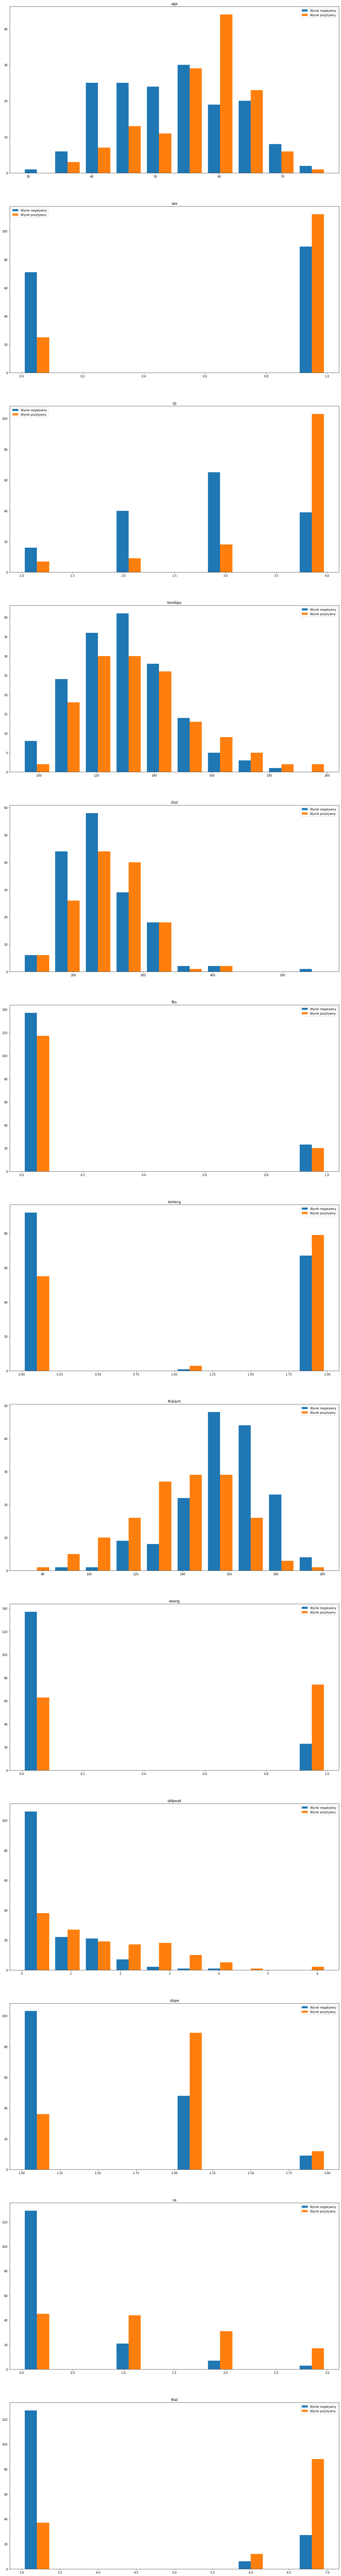

In [16]:
f, axarr = plt.subplots(13, 1, figsize=(20, 160))

for idx, label in enumerate(cleveland_df.columns):
    if idx == 13:
        continue
    axarr[idx].autoscale()
    axarr[idx].hist([cleveland_df[cleveland_df['num'] == -1][label], cleveland_df[cleveland_df['num'] == 1][label]], label=['Wynik negatywny', 'Wynik pozytywny'])
    axarr[idx].legend()
    axarr[idx].set_title(label)
plt.show()

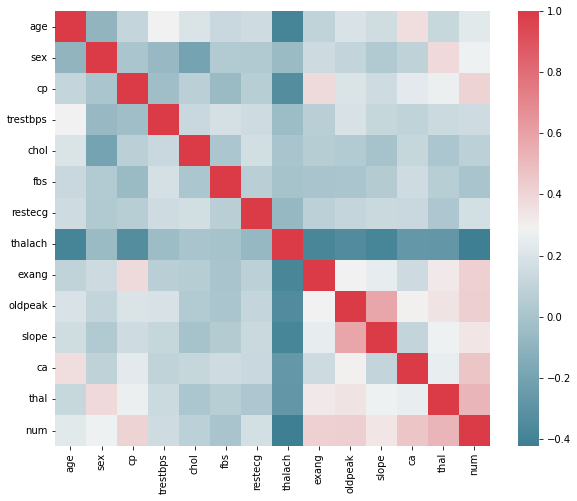

age         0.227075
sex         0.278467
cp          0.408945
trestbps    0.153490
chol        0.080285
fbs         0.003167
restecg     0.166343
thalach    -0.423817
exang       0.421355
oldpeak     0.424052
slope       0.333049
ca          0.463189
thal        0.526640
num         1.000000
Name: num, dtype: float64


In [17]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = cleveland_df.corr()

sns.heatmap(corr, mask=np.zeros_like(corr),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()
print(corr['num'])

Najwiekszą korelacje z przewidywanym wynikiem mają wskaźniki: ca, thal, oldpeak, cp ([2, 9, 11, 12])

## Czesc 3

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
def part_3_1(x, y, alpha=1e-50):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state, shuffle=True)
    x_min = np.min(x_train)
    x_max = np.max(x_train)

    x_train = (x_train - x_min) / (x_max - x_min)
    x_test = (x_test - x_min) / (x_max - x_min)

    w = []
    an_start = time_ns()
    for _ in range(100):
        w = ridge_regression(x_train, y_train, alpha=alpha)
    an_time = time_ns() - an_start

    sk_start = time_ns()
    for _ in range(100):
        model = RidgeClassifier(alpha=alpha).fit(x_train, y_train)
    sk_time = time_ns() - sk_start
    return w, model, an_time, sk_time, x_test, y_test

def compare_effects(w: np.ndarray, model: RidgeClassifier, an_time: float, sk_time: float, x_test: np.ndarray, y_test: np.ndarray):
    y_an_predicted = np.reshape(np.sum(np.dot(np.c_[np.ones((x_test.shape[0], 1)), x_test], w), axis=1, dtype=np.float64), (x_test.shape[0], 1))

    scaler = MinMaxScaler((-1, 1))
    scaler.fit(y_an_predicted)
    y_an_predicted = scaler.transform(y_an_predicted)

    y_an_predicted = assign_labels(f_wielomian(w, x_test))
    y_sk_predicted = model.predict(x_test)

    cm_sk = confusion_matrix(y_test, y_sk_predicted)
    cm_an = confusion_matrix(y_test, y_an_predicted)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

    for idx, cm, title in zip(
        range(2),
        [cm_an, cm_sk],
        ['Implementacja własna', 'Model RidgeClassifier'],
    ):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        axarr[idx].set_title(title)
        disp.plot(ax=axarr[idx])

    print(f'Implementacja własna działała średnio \t{an_time / 100} nanosekund')
    print(f'Implementacja sklearn działała średnio \t{sk_time / 100} nanosekund')

    sensitivity = cm_sk[1, 1] / (cm_sk[1, 0] + cm_sk[1, 1])
    specifity = cm_sk[0, 0] / (cm_sk[0, 0] + cm_sk[0, 1])

    print(f'Czulość: {sensitivity}, swoistość: {specifity}')

    y_score_sk = model.decision_function(x_test)
    y_score_an = f_wielomian(w, x_test)
    fpr, tpr, _ = roc_curve(y_test, y_score_an)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([-0.03, 1.03])
    plt.ylim([0.0, 1.03])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend()
    plt.show()

Implementacja własna działała średnio 	104157.0 nanosekund
Implementacja sklearn działała średnio 	833422.0 nanosekund
Czulość: 0.7368421052631579, swoistość: 0.8780487804878049


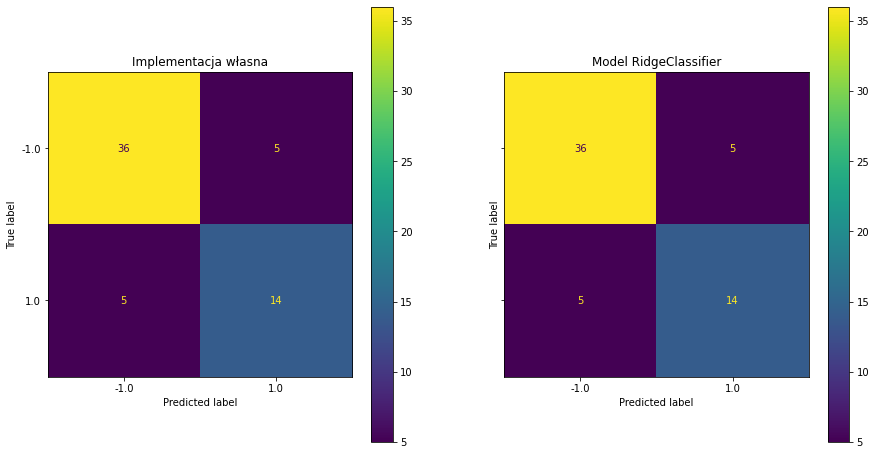

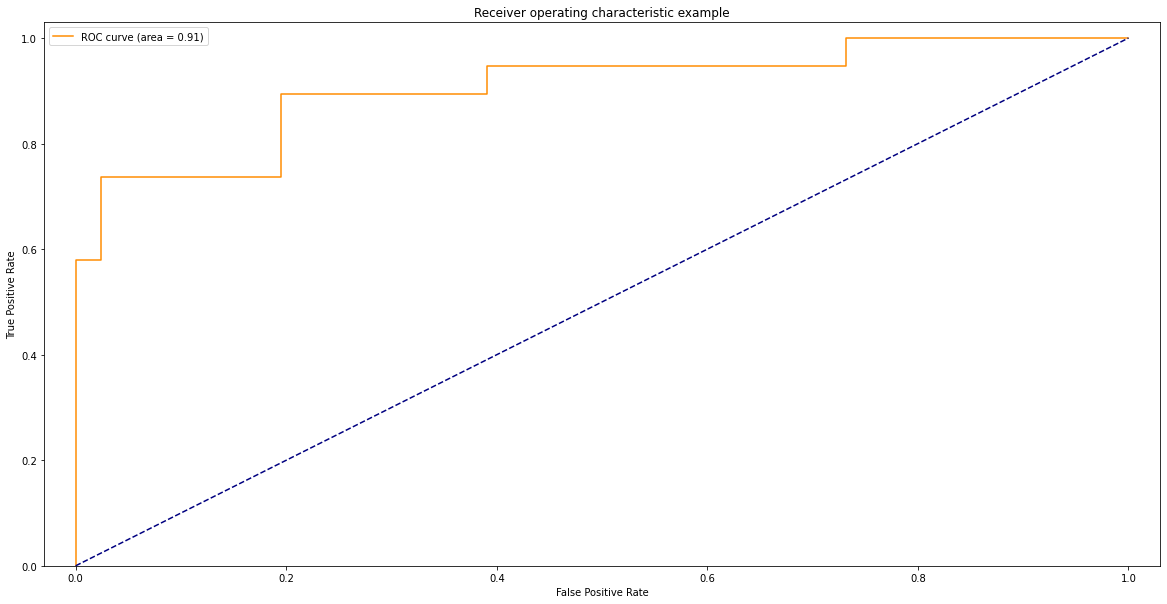

In [20]:
cleveland_all_np = cleveland_df.to_numpy()

cleveland_all_x = cleveland_all_np[:, :-1]
cleveland_all_y = cleveland_all_np[:, -1]
cleveland_all_y[cleveland_all_y == 0] = -1

w, model, an_time, sk_time, x_test, y_test = part_3_1(cleveland_all_x, cleveland_all_y)
compare_effects(w, model, an_time, sk_time, x_test, y_test)

In [21]:
from sklearn.feature_selection import SequentialFeatureSelector

Dane wybrane automatycznie to: [2, 3, 7, 9, 11, 12]
Implementacja własna działała średnio 	79359.0 nanosekund
Implementacja sklearn działała średnio 	4106882.0 nanosekund
Wynik sklearn: 		Czulość: 0.7894736842105263, swoistość: 0.8292682926829268
Wynik analityczny: 	Czulosc: 0.7894736842105263, swoistość: 0.8048780487804879


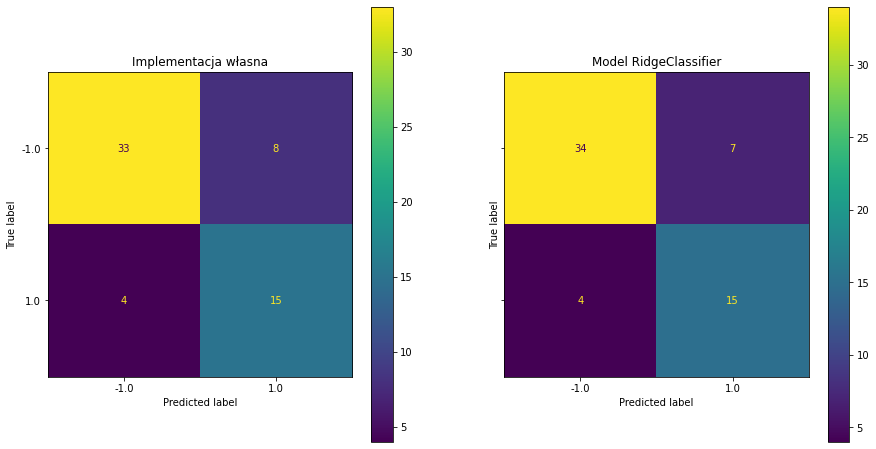

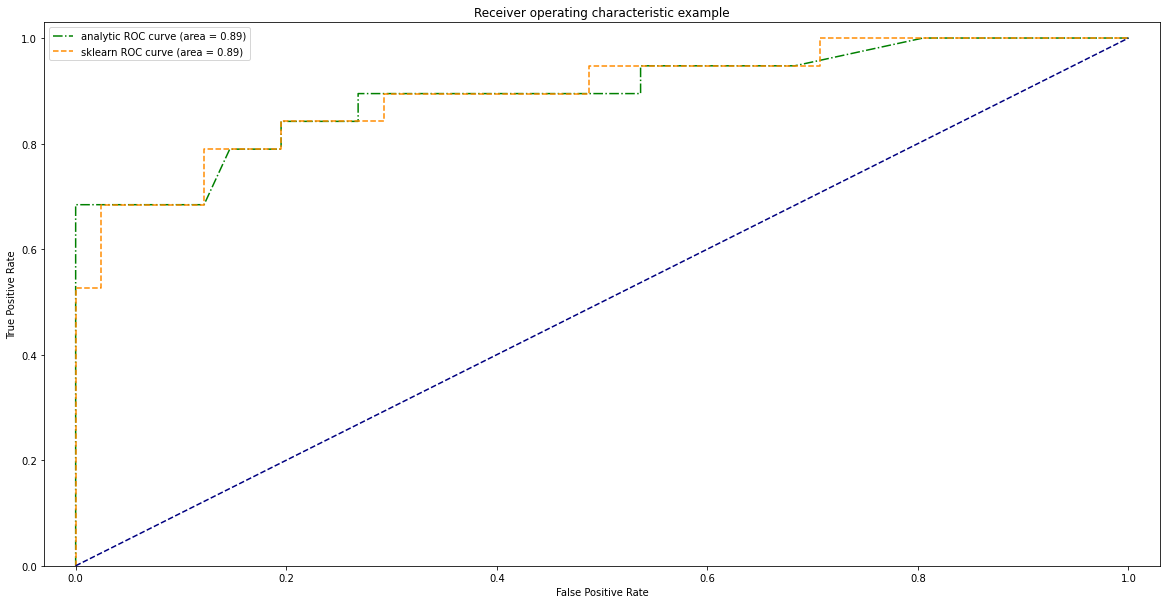

In [22]:

def part_3_2(data, alpha=1e-50):
    an_4_x = data[['ca', 'thal', 'oldpeak', 'cp']].to_numpy()
    an_4_y = data['num'].to_numpy()

    an_x_train, an_x_test, an_y_train, an_y_test = train_test_split(an_4_x, an_4_y, test_size=0.2, random_state=random_state, shuffle=True)
    x_min = np.min(an_x_train)
    x_max = np.max(an_x_train)

    an_x_train = (an_x_train - x_min) / (x_max - x_min)
    an_x_test = (an_x_test - x_min) / (x_max - x_min)

    w = []
    an_start = time_ns()
    for _ in range(100):
        w = ridge_regression(an_x_train, an_y_train, alpha=alpha)
    an_time = time_ns() - an_start

    temp = data.to_numpy()
    x = temp[:, :-1]
    y = temp[:, -1]

    sk_x_train, sk_x_test, sk_y_train, sk_y_test = train_test_split(x, y, test_size=0.2, random_state=random_state, shuffle=True)
    sk_start = time_ns()
    # for _ in range(100):
    model = Pipeline([
        ('feature_selection', SequentialFeatureSelector(RidgeClassifier(alpha=alpha))),
        ('classification', RidgeClassifier(alpha))
    ])
    model.fit(sk_x_train, sk_y_train)
    sk_time = time_ns() - sk_start

    print(f'Dane wybrane automatycznie to: {[i for i in range(len(model["feature_selection"].get_support())) if model["feature_selection"].get_support()[i]]}')

    y_an_predicted = np.reshape(np.sum(np.dot(np.c_[np.ones((an_x_test.shape[0], 1)), an_x_test], w), axis=1, dtype=np.float64), (an_x_test.shape[0], 1))

    scaler = MinMaxScaler((-1, 1))
    scaler.fit(y_an_predicted)
    # y_an_predicted = scaler.transform(y_an_predicted)

    y_an_predicted = assign_labels(f_wielomian(w, an_x_test))
    y_sk_predicted = model.predict(sk_x_test)

    cm_sk = confusion_matrix(sk_y_test, y_sk_predicted)
    cm_an = confusion_matrix(an_y_test, y_an_predicted)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

    for idx, cm, title in zip(
        range(2),
        [cm_an, cm_sk],
        ['Implementacja własna', 'Model RidgeClassifier'],
    ):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        axarr[idx].set_title(title)
        disp.plot(ax=axarr[idx])

    print(f'Implementacja własna działała średnio \t{an_time / 100} nanosekund')
    print(f'Implementacja sklearn działała średnio \t{sk_time / 100} nanosekund')

    sensitivity_sk = cm_sk[1, 1] / (cm_sk[1, 0] + cm_sk[1, 1])
    specifity_sk = cm_sk[0, 0] / (cm_sk[0, 0] + cm_sk[0, 1])

    sensitivity_an = cm_an[1, 1] / (cm_an[1, 0] + cm_an[1, 1])
    specifity_an = cm_an[0, 0] / (cm_an[0, 0] + cm_an[0, 1])

    print(f'Wynik sklearn: \t\tCzulość: {sensitivity_sk}, swoistość: {specifity_sk}')
    print(f'Wynik analityczny: \tCzulosc: {sensitivity_an}, swoistość: {specifity_an}')

    y_score_an = f_wielomian(w, an_x_test)
    fpr_an, tpr_an, _ = roc_curve(an_y_test, y_score_an)
    roc_auc_an = auc(fpr_an, tpr_an)

    y_score_sk = model.decision_function(x_test)
    fpr_sk, tpr_sk, _ = roc_curve(y_test, y_score_sk)
    roc_auc_sk = auc(fpr_sk, tpr_sk)

    plt.figure()
    plt.plot(
        fpr_an,
        tpr_an,
        color="green",
        label="analytic ROC curve (area = %0.2f)" % roc_auc_an,
        linestyle="dashdot"
    )
    plt.plot(
        fpr_sk,
        tpr_sk,
        color='darkorange',
        label="sklearn ROC curve (area = %0.2f)" % roc_auc_sk,
        linestyle="--"
    )
    plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
    plt.xlim([-0.03, 1.03])
    plt.ylim([0.0, 1.03])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend()
    plt.show()


part_3_2(cleveland_df)